In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [3]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import emoji
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec


from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srishti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/srishti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df = pd.read_csv('Twitter_Data.csv')
print(df.head())
print(df.info())
print(df.duplicated().sum())
print(df.label.value_counts())


                                                text  label
0  when modi promised “minimum government maximum...   -1.0
1  talk all the nonsense and continue all the dra...    0.0
2  what did just say vote for modi  welcome bjp t...    1.0
3  asking his supporters prefix chowkidar their n...    1.0
4  answer who among these the most powerful world...    1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162969 entries, 0 to 162968
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    162969 non-null  object 
 1   label   162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB
None
0
 1.0    72249
 0.0    55211
-1.0    35509
Name: label, dtype: int64


In [28]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import *
import nltk
from nltk.stem.snowball import SnowballStemmer

import nltk
from nltk.stem.snowball import SnowballStemmer

In [39]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def clean_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text


#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def porter_stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

def SnowballStemmer(text):
    tokenized = nltk.word_tokenize(text)
    ss = SnowballStemmer()
    return ' '.join([ss.stem(words) for words in tokenized])

    print(' '.join(stemWords))

def Lancaster_Stemmmer(text):
    tokenized = nltk.word_tokenize(text)
    ls = LancasterStemmer()
    return ' '.join([ls.stem(words) for words in tokenized])

#Lemmatization 
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.stem(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    # print("-",text)
    text = strip_all_entities(text)
    # print("-",text)
    text = clean_hashtags(text)
    # print("-",text)
    text = filter_chars(text)
    # print("-",text)
    text = remove_mult_spaces(text)
    # print("-",text)
    text = porter_stemmer(text)
    # print("-",text)
    return text

In [40]:
texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))

In [41]:
df['text_clean'] = texts_new
df.head()

,text,label,text_clean
0,when modi promised “minimum government maximum...,-1.0,modi promis minimum govern maximum govern expe...
1,talk all the nonsense and continue all the dra...,0.0,talk nonsens continu drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,say vote modi welcom bjp told rahul main campa...
3,asking his supporters prefix chowkidar their n...,1.0,ask support prefix chowkidar name modi great s...
4,answer who among these the most powerful world...,1.0,answer among power world leader today trump pu...


In [42]:
df = df[df['label'] != -1]
df

,text,label,text_clean
1,talk all the nonsense and continue all the dra...,0.0,talk nonsens continu drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,say vote modi welcom bjp told rahul main campa...
3,asking his supporters prefix chowkidar their n...,1.0,ask support prefix chowkidar name modi great s...
4,answer who among these the most powerful world...,1.0,answer among power world leader today trump pu...
5,kiya tho refresh maarkefir comment karo,0.0,kiya tho refresh maarkefir comment karo
...,...,...,...
162962,modi promised 2014 lok sabha elections that be...,1.0,modi promis 2014 lok sabha elect best orop giv...
162963,save your agenda peddling ’ had with terror at...,0.0,save agenda peddl terror attack everi second d...
162966,did you cover her interaction forum where she ...,0.0,cover interact forum left
162967,there big project came into india modi dream p...,0.0,big project came india modi dream project happ...


In [44]:
print(df["text_clean"].duplicated().sum())
print(df.shape)
print(df.drop_duplicates("text_clean", inplace=True))
print(df.shape)
print(df.label.value_counts())

0
(122901, 3)
None
(122901, 3)
1.0    70475
0.0    52426
Name: label, dtype: int64


In [45]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df['text_len'] = text_len

/Users/srishti/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


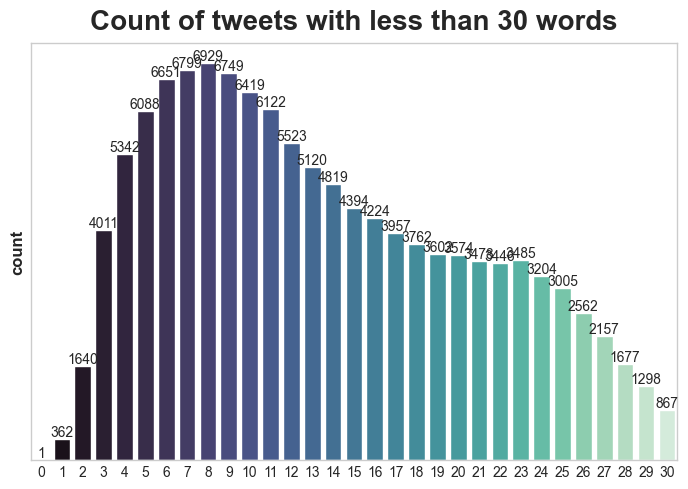

In [46]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<=30], palette='mako')
plt.title('Count of tweets with less than 30 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [47]:
df = df[df['text_len'] > 2]
df.sort_values(by=['text_len'], ascending=False)

,text,label,text_clean,text_len
24787,sir vaada toh yeah aisay kartey hai jaisay apn...,1.0,sir vaada toh yeah aisay kartey hai jaisay apn...,43
84302,modi plz check some institutes nehru built\ndr...,0.0,modi plz check institut nehru built drdo csir ...,42
51367,piyush sir upa2 project whats bjp modi did toh...,0.0,piyush sir upa2 project what bjp modi toh part...,42
42764,mother law government employee shares her expe...,0.0,mother law govern employe share experi itn saa...,41
64353,dalal media shuru gya modi plz check some inst...,0.0,dalal media shuru gya modi plz check institut ...,41
...,...,...,...,...
33322,don’ take tension sirvote for again,0.0,take tension sirvot,3
26208,vote for modi government,0.0,vote modi govern,3
33317,you are chamcha modi and bjp,0.0,chamcha modi bjp,3
70697,call babban riga,0.0,call babban riga,3


/Users/srishti/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


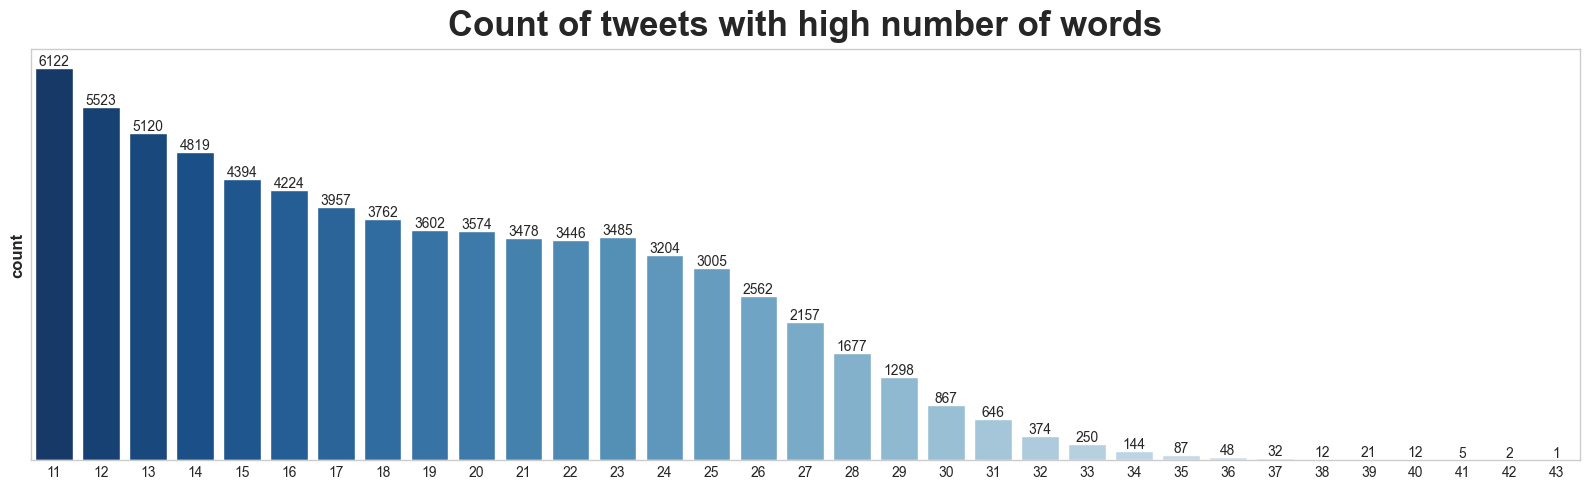

In [48]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=100) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [49]:
df = df[df['text_len'] < 100]
max_len = np.max(df['text_len'])
print(max_len)
df.sort_values(by=["text_len"], ascending=False)

43


,text,label,text_clean,text_len
24787,sir vaada toh yeah aisay kartey hai jaisay apn...,1.0,sir vaada toh yeah aisay kartey hai jaisay apn...,43
84302,modi plz check some institutes nehru built\ndr...,0.0,modi plz check institut nehru built drdo csir ...,42
51367,piyush sir upa2 project whats bjp modi did toh...,0.0,piyush sir upa2 project what bjp modi toh part...,42
42764,mother law government employee shares her expe...,0.0,mother law govern employe share experi itn saa...,41
64353,dalal media shuru gya modi plz check some inst...,0.0,dalal media shuru gya modi plz check institut ...,41
...,...,...,...,...
33322,don’ take tension sirvote for again,0.0,take tension sirvot,3
26208,vote for modi government,0.0,vote modi govern,3
33317,you are chamcha modi and bjp,0.0,chamcha modi bjp,3
70697,call babban riga,0.0,call babban riga,3


In [54]:
# find data types of each column
print(df.dtypes)
# convert label to long 
df['label'] = df['label'].astype('int64')
print(df.dtypes)

text          object
label          int64
text_clean    object
text_len       int64
dtype: object
text          object
label          int64
text_clean    object
text_len       int64
dtype: object


In [55]:
X = df['text_clean']
y = df['label']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [58]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 36540],
       [    1, 50506]])

In [59]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [60]:
max_len

43

In [62]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [63]:
df["text_clean"].iloc[16]

'dont play word talk modi swami relat guru say good chowkidar protect good mind tweet dark side terror brighter side better know'

In [64]:
tokenized_column[16]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   19,
        319,  270,   96,    1,  984,  656, 1967,   10,   29,   48,  664,
         29,  299,  151, 2533,  497,  330, 5910,  497,   85,   24])

In [66]:
keys = []
values = []
for key, value in vocabulary[:20]:
    print(key, value)
    keys.append(key)
    values.append(value)

modi 120965
india 23252
bjp 11140
peopl 9966
elect 9845
like 9664
vote 9548
congress 9103
narendra 9098
say 8148
nation 7990
govt 7358
one 7111
indian 6814
time 6789
year 6481
countri 6412
want 6077
dont 5957
give 5925


/Users/srishti/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


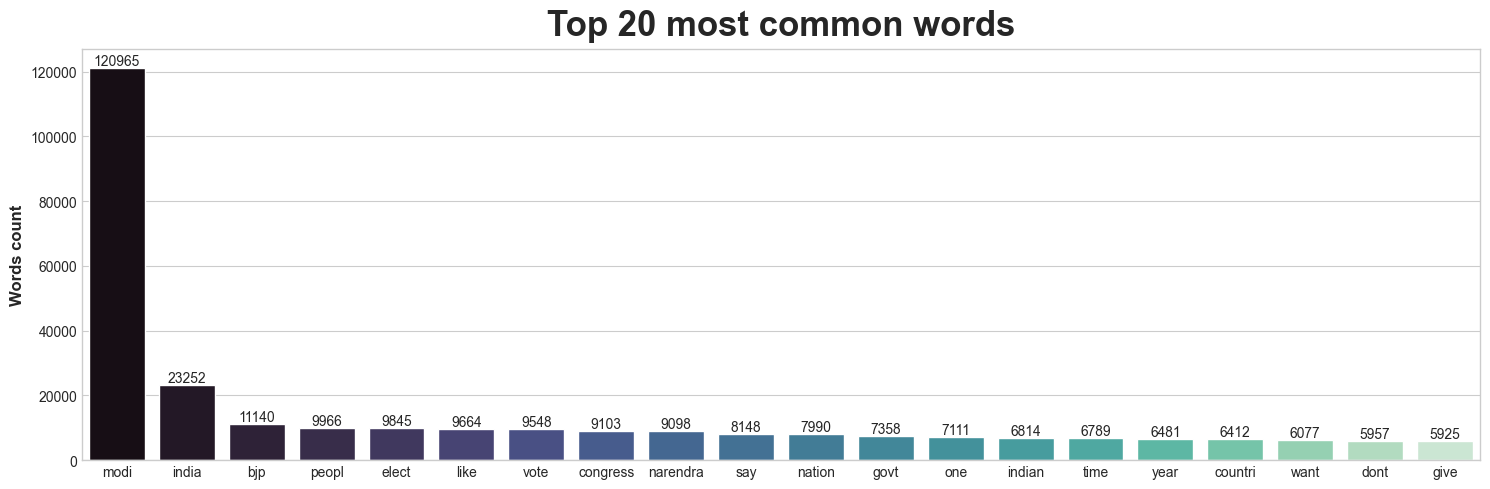

In [67]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys, y=values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

In [68]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))
EMBEDDING_DIM = 200
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)
print(f"Vocabulary size: {len(vocabulary) + 1}")



Vocabulary size: 67299


In [69]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding
from tqdm import tqdm


In [70]:
#define empty embedding matrix

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
   
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for i , (word, token) in enumerate(vocabulary):
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[i] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (67299, 200)


In [71]:
df['label']=df['label'].replace(-1,0)

In [72]:
X = tokenized_column
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)


In [73]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 36540],
       [    1, 50506]])

In [74]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [75]:
BATCH_SIZE = 64

In [76]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [78]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2 #2-layer stacked LSTM
num_classes = 2

In [79]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [88]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,num_classes, vocab_size, embedding_dim):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) #batch_first for shape (batch,seq_no,features)
        self.fc = nn.Linear(hidden_size,num_classes)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
    def forward(self,X_batch):
        hidden_0 = torch.zeros(self.num_layers, X_batch.size(0), self.hidden_size).to(DEVICE)
        cellstate_0 = torch.zeros(self.num_layers, X_batch.size(0),self.hidden_size).to(DEVICE)
        
        output,_ = self.lstm(X_batch, (hidden_0,cellstate_0))
        #output shape is (batch_size,seq_no,hidden_size)
        # we need hidden_state of the last element in the sequence for each of the batch inputs
        output = self.fc(output[:,-1,:])
        return output
    
    def train_step(self,X_batch):
        images,labels = X_batch
        images = images.reshape(-1,sequence_length,input_size)
        output = model(images)
        loss = F.cross_entropy(output,labels)
        return loss
    
    def test_step(self,X_batch):
        images,labels = X_batch
        images = images.reshape(-1,sequence_length,input_size)
        output = model(images)
        loss = F.cross_entropy(output,labels)
        _,preds = torch.max(output,dim=1)
        acc = torch.tensor(torch.sum(preds==labels).item()/len(preds))
        return {'loss':loss,'acc':acc}
    
    

In [89]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    else:
        return data.to(device,non_blocking=True)
    
class DeviceDataLoader():
    #Wrap dataloader to move data to device
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch,self.device)
    
    def __len__(self):
        return len(self.dl)

In [90]:
device = get_default_device()

In [91]:
device = torch.device('cpu')

In [92]:
model = RNN(input_size, hidden_size, num_layers, num_classes)
to_device(model,device)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [93]:
train_loader = DeviceDataLoader(train_loader,device)
valid_loader = DeviceDataLoader(valid_loader,device)
test_loader = DeviceDataLoader(test_loader,device)

In [94]:
@torch.no_grad()
def evaluate(model,test_loader):
    outputs = [model.test_step(batch) for batch in test_loader]
    batch_losses = [x['loss'] for x in outputs]
    batch_accs = [x['acc'] for x in outputs]
    loss = torch.stack(batch_losses).mean()
    acc = torch.stack(batch_accs).mean()
    print(f"loss is {loss} and acc is {acc}")

In [95]:
evaluate(model,test_loader)

RuntimeError: shape '[-1, 28, 28]' is invalid for input of size 2752

In [96]:
def train(model,train_loader,test_loader,num_epochs=2,lr=0.01,optim_func=torch.optim.Adam):
    optim = optim_func(model.parameters(),lr=lr)
    for epoch in range(num_epochs):
        for batch in train_loader:
            loss = model.train_step(batch)
            loss.backward()
            optim.step()
            optim.zero_grad()
        evaluate(model,test_loader)

In [97]:
train(model,train_loader,test_loader)

RuntimeError: shape '[-1, 28, 28]' is invalid for input of size 2752